In [1]:
import os
import gc
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
from scipy.fft import dct, idct
from scipy.sparse.linalg import lsqr
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                           roc_auc_score, accuracy_score, precision_score, 
                           recall_score, f1_score)
import warnings
from tqdm import tqdm
import pickle
import json
import time
from datetime import datetime
warnings.filterwarnings('ignore')

# ============================================
# 1. Memory-Optimized Feature Extraction
# ============================================

class MemoryOptimizedMFCCExtractor:
    """
    Memory-optimized MFCC feature extraction
    """
    
    def __init__(self, sr=22050, n_mfcc=20, n_fft=2048, hop_length=512):
        self.sr = sr
        self.n_mfcc = n_mfcc  # Reduced from 40 to 20
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        
    def extract_mfcc_features(self, audio_path):
        """
        Extract optimized MFCC-based features with memory efficiency
        """
        try:
            # Load audio with reduced duration
            y, sr = librosa.load(audio_path, sr=self.sr, duration=2.0)  # Reduced from 4 to 2 seconds
            
            # Zero-padding or truncation for consistent length
            target_length = self.sr * 2  # 2 seconds
            if len(y) < target_length:
                y = np.pad(y, (0, target_length - len(y)), mode='constant')
            else:
                y = y[:target_length]
            
            # Apply pre-emphasis filter
            y = librosa.effects.preemphasis(y)
            
            # Extract base MFCCs with reduced dimension
            mfccs = librosa.feature.mfcc(
                y=y, 
                sr=sr, 
                n_mfcc=self.n_mfcc,
                n_fft=self.n_fft,
                hop_length=self.hop_length
            )
            
            # Extract delta features only (skip delta-delta)
            mfcc_delta = librosa.feature.delta(mfccs)
            
            # Extract reduced set of complementary features
            chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=self.hop_length)
            
            # Root Mean Square Energy
            rms = librosa.feature.rms(y=y, hop_length=self.hop_length)
            
            # Zero Crossing Rate
            zcr = librosa.feature.zero_crossing_rate(y, hop_length=self.hop_length)
            
            # Combine features
            features = np.vstack([
                mfccs,
                mfcc_delta,
                chroma,
                rms,
                zcr
            ])
            
            # Extract reduced statistical features
            feature_stats = self._extract_statistics(features)
            
            # Clean up
            del y, mfccs, mfcc_delta, chroma, rms, zcr, features
            gc.collect()
            
            return feature_stats
            
        except Exception as e:
            print(f"Error processing {audio_path}: {str(e)}")
            # Return smaller vector
            return np.zeros(500)
    
    def _extract_statistics(self, features):
        """
        Extract minimal statistical features
        """
        stats = []
        # Process in chunks to reduce memory
        chunk_size = 5
        for i in range(0, len(features), chunk_size):
            chunk = features[i:i+chunk_size]
            for feature in chunk:
                stats.extend([
                    np.mean(feature),
                    np.std(feature),
                    np.median(feature),
                    np.percentile(feature, 25),
                    np.percentile(feature, 75),
                ])
        return np.array(stats)
    
    def extract_all_features(self, audio_paths, labels=None, batch_size=100):
        """
        Extract features in batches to save memory
        """
        features = []
        valid_labels = []
        
        # Process in batches
        for i in tqdm(range(0, len(audio_paths), batch_size), desc="Extracting features"):
            batch_paths = audio_paths[i:i+batch_size]
            batch_labels = labels[i:i+batch_size] if labels is not None else None
            
            batch_features = []
            batch_valid_labels = []
            
            for idx, path in enumerate(batch_paths):
                feat = self.extract_mfcc_features(path)
                if np.sum(np.abs(feat)) > 0.01 and not np.isnan(feat).any():
                    batch_features.append(feat)
                    if batch_labels is not None:
                        batch_valid_labels.append(batch_labels[idx])
            
            features.extend(batch_features)
            valid_labels.extend(batch_valid_labels)
            
            # Clear memory
            del batch_features
            gc.collect()
        
        if len(features) == 0:
            print("WARNING: No valid features extracted!")
            return np.array([]), np.array([])
        
        features = np.array(features)
        
        # Normalize features
        features = self.scaler.fit_transform(features)
        
        # Encode labels if provided
        if labels is not None and len(valid_labels) > 0:
            encoded_labels = self.label_encoder.fit_transform(valid_labels)
        else:
            encoded_labels = None
        
        return features, encoded_labels

# ============================================
# 2. Memory-Efficient Gaussian Compression
# ============================================

class MemoryEfficientGaussianCompressor:
    """Memory-efficient Gaussian Random Matrix Compression"""
    
    def __init__(self, compression_ratio=0.5, seed=42, noise_level=0.0):
        self.compression_ratio = compression_ratio
        self.seed = seed
        self.noise_level = noise_level
        self.measurement_matrix = None
        
    def create_sparse_gaussian_matrix(self, n_original, n_compressed, density=0.1):
        """
        Create sparse Gaussian random matrix to save memory
        """
        np.random.seed(self.seed)
        
        # Create sparse matrix with random Gaussian entries
        data = np.random.randn(int(n_compressed * n_original * density))
        rows = np.random.randint(0, n_compressed, int(n_compressed * n_original * density))
        cols = np.random.randint(0, n_original, int(n_compressed * n_original * density))
        
        # Normalize by sqrt(density * n_compressed) for proper scaling
        normalization = np.sqrt(density * n_compressed)
        sparse_matrix = sparse.csr_matrix(
            (data / normalization, (rows, cols)), 
            shape=(n_compressed, n_original)
        )
        
        return sparse_matrix
    
    def compress(self, signal):
        """
        Compress signal using sparse Gaussian matrix
        """
        n_original = len(signal)
        n_compressed = max(1, int(n_original * self.compression_ratio))
        
        # Create sparse measurement matrix
        self.measurement_matrix = self.create_sparse_gaussian_matrix(
            n_original, n_compressed, density=0.1
        )
        
        # Compress signal
        compressed_signal = self.measurement_matrix.dot(signal)
        
        # Add optional measurement noise
        if self.noise_level > 0:
            noise = np.random.randn(n_compressed) * self.noise_level
            compressed_signal += noise
        
        return compressed_signal
    
    def reconstruct_omp_fast(self, compressed_signal, sparsity_level=50):
        """
        Fast OMP reconstruction with memory efficiency
        """
        if self.measurement_matrix is None:
            raise ValueError("Measurement matrix not created.")
        
        m, n = self.measurement_matrix.shape
        residual = compressed_signal.copy()
        support = []
        reconstructed_signal = np.zeros(n)
        
        A = self.measurement_matrix.toarray() if sparsity_level < 100 else self.measurement_matrix
        
        for _ in range(min(sparsity_level, m)):
            # Compute correlations efficiently
            if isinstance(A, sparse.csr_matrix):
                correlations = np.abs(A.T.dot(residual))
            else:
                correlations = np.abs(A.T @ residual)
            
            # Avoid selecting the same index
            correlations[support] = -np.inf
            new_idx = np.argmax(correlations)
            support.append(new_idx)
            
            # Solve least squares on current support
            if isinstance(A, sparse.csr_matrix):
                A_support = A[:, support].toarray()
            else:
                A_support = A[:, support]
            
            # Use efficient solver
            try:
                x_support = np.linalg.lstsq(A_support, compressed_signal, rcond=None)[0]
            except:
                # Fallback to pinv for stability
                x_support = np.linalg.pinv(A_support) @ compressed_signal
            
            # Update residual
            residual = compressed_signal - A_support @ x_support
            
            # Early stopping if residual is small
            if np.linalg.norm(residual) < 1e-6:
                break
        
        # Create full reconstructed signal
        reconstructed_signal[support] = x_support[:len(support)]
        
        return reconstructed_signal

# ============================================
# 3. Optimized Feature Extractor
# ============================================

class OptimizedFeatureExtractor(MemoryOptimizedMFCCExtractor):
    """
    Feature extractor with memory-efficient compression
    """
    
    def __init__(self, sr=22050, n_mfcc=20, n_fft=2048, hop_length=512):
        super().__init__(sr, n_mfcc, n_fft, hop_length)
        
    def extract_features_with_compression(self, audio_path, compression_method='gaussian', 
                                          compression_ratio=0.5, noise_level=0.0):
        """
        Memory-efficient feature extraction with compression
        """
        # Extract original features
        original_features = self.extract_mfcc_features(audio_path)
        
        if compression_method == 'none' or compression_ratio >= 1.0:
            return original_features, original_features, {'method': 'none', 'ratio': 1.0}
        
        # Ensure features are 1D
        features_1d = original_features.flatten()
        
        # Limit maximum feature dimension
        max_dim = 1000  # Cap feature dimension
        if len(features_1d) > max_dim:
            features_1d = features_1d[:max_dim]
        elif len(features_1d) < max_dim:
            features_1d = np.pad(features_1d, (0, max_dim - len(features_1d)), 'constant')
        
        # Apply compression
        if compression_method == 'gaussian':
            compressor = MemoryEfficientGaussianCompressor(
                compression_ratio=compression_ratio, 
                noise_level=noise_level
            )
            compressed_features = compressor.compress(features_1d)
            compression_info = {
                'method': 'gaussian',
                'ratio': compression_ratio,
                'original_length': len(features_1d),
                'compressed_length': len(compressed_features),
                'noise_level': noise_level
            }
            
        else:
            # For other methods, use simpler compression
            n_keep = int(len(features_1d) * compression_ratio)
            compressed_features = features_1d[:n_keep]
            compression_info = {
                'method': compression_method,
                'ratio': compression_ratio,
                'original_length': len(features_1d),
                'compressed_length': n_keep
            }
        
        return compressed_features, original_features, compression_info

# ============================================
# 4. Memory-Optimized Experiment Pipeline
# ============================================

class MemoryOptimizedCompressionExperiment:
    """
    Memory-optimized pipeline for compression experiments
    """
    
    def __init__(self, dataset_path, output_dir='optimized_results'):
        self.dataset_path = dataset_path
        self.output_dir = output_dir
        os.makedirs(output_dir, exist_ok=True)
        
        # Reduced experiment configurations
        self.compression_methods = ['gaussian', 'none']
        self.compression_ratios = [0.25, 0.5, 0.75]
        self.noise_levels = [0.0]
        self.classifiers = {
            'random_forest': RandomForestClassifier(
                n_estimators=50,  # Reduced from 100
                max_depth=10,
                random_state=42,
                n_jobs=-1
            ),
            'linear_svm': LinearSVC(
                random_state=42,
                max_iter=1000
            ),
        }
        
    def run_subset_experiment(self, sample_size=1000):
        """
        Run experiment on a subset of data
        """
        print("="*70)
        print("MEMORY-OPTIMIZED COMPRESSION EXPERIMENT")
        print("="*70)
        
        # Initialize processor and extractor
        processor = UrbanSound8KProcessor(self.dataset_path)
        extractor = OptimizedFeatureExtractor()
        
        # Get all data
        print("\nLoading dataset metadata...")
        all_paths, all_labels, _ = processor.prepare_data(list(range(1, 11)))
        
        # Sample subset for faster processing
        if sample_size < len(all_paths):
            indices = np.random.choice(len(all_paths), sample_size, replace=False)
            all_paths = [all_paths[i] for i in indices]
            all_labels = [all_labels[i] for i in indices]
        
        # Split into train/test
        print(f"\nUsing {len(all_paths)} samples total")
        train_paths, test_paths, train_labels, test_labels = train_test_split(
            all_paths, all_labels, test_size=0.2, random_state=42, stratify=all_labels
        )
        
        print(f"Training set: {len(train_paths)} samples")
        print(f"Test set: {len(test_paths)} samples")
        
        # Encode labels
        label_encoder = LabelEncoder()
        y_train = label_encoder.fit_transform(train_labels)
        y_test = label_encoder.transform(test_labels)
        
        # Store results
        all_results = []
        
        # Test only key configurations
        for method in ['none', 'gaussian']:
            for ratio in [0.25, 0.5, 0.75] if method != 'none' else [1.0]:
                print(f"\n{'='*50}")
                print(f"Testing: {method.upper()} (Ratio: {ratio})")
                print('='*50)
                
                # Extract features
                X_train_features = []
                X_test_features = []
                
                # Process training data
                print("Extracting training features...")
                for path in tqdm(train_paths, desc=f"Training {method}"):
                    compressed_feat, _, _ = extractor.extract_features_with_compression(
                        path, method, ratio, noise_level=0.0
                    )
                    X_train_features.append(compressed_feat)
                
                # Process test data
                print("Extracting test features...")
                for path in tqdm(test_paths, desc=f"Testing {method}"):
                    compressed_feat, _, _ = extractor.extract_features_with_compression(
                        path, method, ratio, noise_level=0.0
                    )
                    X_test_features.append(compressed_feat)
                
                # Convert to arrays
                X_train = np.array(X_train_features)
                X_test = np.array(X_test_features)
                
                # Standardize
                scaler = StandardScaler()
                X_train_scaled = scaler.fit_transform(X_train)
                X_test_scaled = scaler.transform(X_test)
                
                # Train and evaluate classifiers
                for clf_name, clf in self.classifiers.items():
                    print(f"  Training {clf_name}...")
                    
                    start_time = time.time()
                    clf.fit(X_train_scaled, y_train)
                    train_time = time.time() - start_time
                    
                    start_time = time.time()
                    y_pred = clf.predict(X_test_scaled)
                    test_time = time.time() - start_time
                    
                    # Calculate metrics
                    accuracy = accuracy_score(y_test, y_pred)
                    precision = precision_score(y_test, y_pred, average='weighted')
                    recall = recall_score(y_test, y_pred, average='weighted')
                    f1 = f1_score(y_test, y_pred, average='weighted')
                    
                    # Store results
                    result = {
                        'compression_method': method,
                        'compression_ratio': ratio,
                        'classifier': clf_name,
                        'accuracy': accuracy,
                        'precision': precision,
                        'recall': recall,
                        'f1_score': f1,
                        'train_time': train_time,
                        'test_time': test_time,
                        'feature_dim': X_train.shape[1],
                        'compression_rate': (1 - ratio) * 100 if method != 'none' else 0,
                        'sample_size': len(train_paths)
                    }
                    
                    all_results.append(result)
                    
                    print(f"    Accuracy: {accuracy:.4f}, F1: {f1:.4f}, Features: {X_train.shape[1]}")
                
                # Clear memory
                del X_train, X_test, X_train_scaled, X_test_scaled
                gc.collect()
        
        # Save results
        self.save_optimized_results(all_results)
        
        return all_results
    
    def save_optimized_results(self, results):
        """Save results efficiently"""
        results_df = pd.DataFrame(results)
        results_df.to_csv(os.path.join(self.output_dir, 'optimized_results.csv'), index=False)
        
        # Create summary
        summary = {
            'experiment_date': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            'total_experiments': len(results),
            'best_accuracy': results_df['accuracy'].max(),
            'best_config': results_df.loc[results_df['accuracy'].idxmax()].to_dict()
        }
        
        with open(os.path.join(self.output_dir, 'summary.json'), 'w') as f:
            json.dump(summary, f, indent=2)
        
        # Create simple visualization
        self.create_simple_plots(results_df)
        
        print(f"\nResults saved to {self.output_dir}/")
    
    def create_simple_plots(self, results_df):
        """Create minimal visualizations"""
        plt.figure(figsize=(10, 6))
        
        for clf in results_df['classifier'].unique():
            clf_df = results_df[results_df['classifier'] == clf]
            
            # Filter out 'none' method for ratio plot
            compression_df = clf_df[clf_df['compression_method'] != 'none']
            if not compression_df.empty:
                plt.plot(compression_df['compression_ratio'], 
                        compression_df['accuracy'], 
                        'o-', label=f'{clf}')
        
        plt.xlabel('Compression Ratio', fontsize=12)
        plt.ylabel('Accuracy', fontsize=12)
        plt.title('Accuracy vs Compression Ratio', fontsize=14)
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(self.output_dir, 'accuracy_vs_ratio.png'), dpi=150)
        plt.show()
        
        # Bar plot comparing methods
        plt.figure(figsize=(8, 5))
        
        method_accuracies = []
        method_labels = []
        
        for method in results_df['compression_method'].unique():
            method_df = results_df[results_df['compression_method'] == method]
            if not method_df.empty:
                method_accuracies.append(method_df['accuracy'].mean())
                method_labels.append(method)
        
        plt.bar(method_labels, method_accuracies)
        plt.xlabel('Compression Method', fontsize=12)
        plt.ylabel('Average Accuracy', fontsize=12)
        plt.title('Average Accuracy by Compression Method', fontsize=14)
        plt.tight_layout()
        plt.savefig(os.path.join(self.output_dir, 'method_comparison.png'), dpi=150)
        plt.show()

# ============================================
# 5. Quick Demo Function
# ============================================

def run_quick_demo():
    """Run a quick demonstration with minimal memory usage"""
    print("🚀 Running Quick Demo of Gaussian Compression")
    print("="*60)
    
    # Generate small test signal
    np.random.seed(42)
    test_signal = np.random.randn(256)
    print(f"Test signal shape: {test_signal.shape}")
    
    # Test sparse Gaussian compression
    print("\n1. Testing Sparse Gaussian Compression:")
    compressor = MemoryEfficientGaussianCompressor(compression_ratio=0.5)
    compressed = compressor.compress(test_signal)
    print(f"   Original: {len(test_signal)} → Compressed: {len(compressed)}")
    print(f"   Compression: {(1 - len(compressed)/len(test_signal)) * 100:.1f}%")
    
    # Test reconstruction
    print("\n2. Testing Fast OMP Reconstruction:")
    reconstructed = compressor.reconstruct_omp_fast(compressed, sparsity_level=30)
    mse = np.mean((test_signal - reconstructed[:len(test_signal)]) ** 2)
    print(f"   Reconstruction MSE: {mse:.6f}")
    print(f"   Relative error: {mse/np.mean(test_signal**2)*100:.2f}%")
    
    print("\n✅ Quick demo completed successfully!")

# ============================================
# 6. Progressive Experiment Function
# ============================================

def run_progressive_experiments():
    """Run experiments progressively with increasing complexity"""
    print("🔬 Progressive Gaussian Compression Experiments")
    print("="*60)
    
    DATASET_PATH = "UrbanSound8K"
    
    if not os.path.exists(DATASET_PATH):
        print(f"Dataset not found at {DATASET_PATH}")
        print("Please download UrbanSound8K dataset first.")
        return
    
    # Step 1: Very small test
    print("\n📊 Step 1: Tiny Test (100 samples)")
    print("-"*40)
    
    experiment = MemoryOptimizedCompressionExperiment(DATASET_PATH, 'tiny_results')
    results_tiny = experiment.run_subset_experiment(sample_size=100)
    
    # Step 2: Medium test
    print("\n📊 Step 2: Medium Test (500 samples)")
    print("-"*40)
    
    experiment = MemoryOptimizedCompressionExperiment(DATASET_PATH, 'medium_results')
    results_medium = experiment.run_subset_experiment(sample_size=500)
    
    # Step 3: Full test (if memory allows)
    response = input("\nDo you want to run a larger test (2000 samples)? (yes/no): ")
    if response.lower() in ['yes', 'y']:
        print("\n📊 Step 3: Larger Test (2000 samples)")
        print("-"*40)
        
        experiment = MemoryOptimizedCompressionExperiment(DATASET_PATH, 'large_results')
        results_large = experiment.run_subset_experiment(sample_size=2000)
    
    print("\n" + "="*60)
    print("All experiments completed!")
    print("Check the results in the output directories:")
    print("  - tiny_results/")
    print("  - medium_results/")
    print("  - large_results/ (if run)")
    print("="*60)

# ============================================
# 7. Main Function with Options
# ============================================

def main():
    """Main function with menu options"""
    print("🎵 Memory-Optimized Gaussian Compression Experiments")
    print("="*70)
    
    print("\nChoose an option:")
    print("1. Quick demo (fast, no dataset required)")
    print("2. Progressive experiments (start small, scale up)")
    print("3. Custom experiment (specify parameters)")
    
    choice = input("\nEnter your choice (1-3): ").strip()
    
    if choice == "1":
        run_quick_demo()
    
    elif choice == "2":
        DATASET_PATH = "UrbanSound8K"
        if not os.path.exists(DATASET_PATH):
            print(f"\n❌ Dataset not found at {DATASET_PATH}")
            print("Please download UrbanSound8K dataset first.")
            print("Download from: https://urbansounddataset.weebly.com/urbansound8k.html")
            return
        run_progressive_experiments()
    
    elif choice == "3":
        print("\nCustom experiment setup:")
        sample_size = int(input("Enter sample size (100-5000): "))
        compression_ratios = input("Enter compression ratios (comma-separated, e.g., 0.25,0.5,0.75): ")
        ratios = [float(x.strip()) for x in compression_ratios.split(',')]
        
        DATASET_PATH = "UrbanSound8K"
        if not os.path.exists(DATASET_PATH):
            print(f"\n❌ Dataset not found at {DATASET_PATH}")
            return
        
        experiment = MemoryOptimizedCompressionExperiment(DATASET_PATH, 'custom_results')
        # Modify experiment parameters
        experiment.compression_ratios = ratios
        results = experiment.run_subset_experiment(sample_size=sample_size)
        
        print(f"\nCustom experiment completed! Results in custom_results/")
    
    else:
        print("Invalid choice. Please run again.")

# ============================================
# UrbanSound8K Processor (same as before but included for completeness)
# ============================================

class UrbanSound8KProcessor:
    """
    Process UrbanSound8K dataset
    """
    
    def __init__(self, dataset_path):
        self.dataset_path = dataset_path
        self.metadata_path = os.path.join(dataset_path, 'metadata', 'UrbanSound8K.csv')
        if not os.path.exists(self.metadata_path):
            self.metadata_path = os.path.join(dataset_path, 'UrbanSound8K.csv')
        
        if not os.path.exists(self.metadata_path):
            raise FileNotFoundError(f"Metadata file not found at {self.metadata_path}")
        
        self.metadata = pd.read_csv(self.metadata_path)
        
    def prepare_data(self, folds=None):
        """
        Prepare data for specific folds or all folds
        """
        if folds is None:
            folds = list(range(1, 11))
        elif isinstance(folds, int):
            folds = [folds]
        
        audio_paths = []
        labels = []
        
        for fold in folds:
            fold_data = self.metadata[self.metadata['fold'] == fold]
            
            for _, row in fold_data.iterrows():
                # Try different possible paths
                possible_paths = [
                    os.path.join(self.dataset_path, 'fold' + str(row['fold']), row['slice_file_name']),
                    os.path.join(self.dataset_path, 'audio', 'fold' + str(row['fold']), row['slice_file_name']),
                    os.path.join(self.dataset_path, str(row['fold']), row['slice_file_name'])
                ]
                
                for path in possible_paths:
                    if os.path.exists(path):
                        audio_paths.append(path)
                        labels.append(row['class'])
                        break
        
        return audio_paths, labels, folds

# ============================================
# Run the program
# ============================================

if __name__ == "__main__":
    main()

🎵 Memory-Optimized Gaussian Compression Experiments

Choose an option:
1. Quick demo (fast, no dataset required)
2. Progressive experiments (start small, scale up)
3. Custom experiment (specify parameters)



Enter your choice (1-3):  2


🔬 Progressive Gaussian Compression Experiments

📊 Step 1: Tiny Test (100 samples)
----------------------------------------
MEMORY-OPTIMIZED COMPRESSION EXPERIMENT

Loading dataset metadata...

Using 100 samples total


ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

🎵 Memory-Safe Audio Compression with Gaussian Random Matrix

OPTIONS:
1. Run minimal demonstration
2. Run memory-safe experiment
3. Quick memory test only
4. Exit



Enter your choice (1-4):  2


MEMORY-SAFE AUDIO COMPRESSION EXPERIMENT
Available memory: 22396 MB
Running memory-safe quick test...
Test signal shape: (256,)
Memory usage: 1.00 KB

1. Sparse Gaussian Compression (50%):
   Compressed shape: (128,)
   Compression ratio: 50.0%
   Matrix sparsity: 9.5%

2. Simple Reconstruction:
   Reconstruction MSE: 0.455005
   Signal energy: 242.93

✅ Memory-safe quick test completed!

EXPERIMENT SCALE OPTIONS:
1. Quick test (100 train, 50 test samples)
2. Small experiment (500 train, 200 test samples)
3. Full experiment (7079 train, 1653 test samples)



Choose experiment scale (1-3, or 'q' to quit):  3



Running MEDIUM experiment...

Starting experiment with 7079 train, 1653 test samples
This may take several minutes...
SIMPLIFIED COMPRESSION-CLASSIFICATION EXPERIMENT

Preparing limited data...
Found 4612 audio files
Found 1653 audio files
Training samples: 4612
Testing samples: 1653

Testing Compression Ratio: 25%
Processing training data...


Extracting & Compressing: 100%|████████████████████████████████████████████████████████| 93/93 [10:16<00:00,  6.63s/it]


Processing test data...


Extracting & Compressing: 100%|████████████████████████████████████████████████████████| 34/34 [03:48<00:00,  6.72s/it]



  Training random_forest...
    Accuracy: 0.4380
    F1 Score: 0.4316
    Train Time: 0.21s
    Feature Dimension: 6

  Training svm...
    Accuracy: 0.4428
    F1 Score: 0.4331
    Train Time: 3.44s
    Feature Dimension: 6

Testing Compression Ratio: 50%
Processing training data...


Extracting & Compressing: 100%|████████████████████████████████████████████████████████| 93/93 [11:00<00:00,  7.10s/it]


Processing test data...


Extracting & Compressing: 100%|████████████████████████████████████████████████████████| 34/34 [03:52<00:00,  6.85s/it]



  Training random_forest...
    Accuracy: 0.5439
    F1 Score: 0.5436
    Train Time: 0.26s
    Feature Dimension: 12

  Training svm...
    Accuracy: 0.5826
    F1 Score: 0.5794
    Train Time: 3.30s
    Feature Dimension: 12

Testing Compression Ratio: 75%
Processing training data...


Extracting & Compressing: 100%|████████████████████████████████████████████████████████| 93/93 [11:06<00:00,  7.17s/it]


Processing test data...


Extracting & Compressing: 100%|████████████████████████████████████████████████████████| 34/34 [03:52<00:00,  6.85s/it]



  Training random_forest...
    Accuracy: 0.5172
    F1 Score: 0.5122
    Train Time: 0.31s
    Feature Dimension: 18

  Training svm...
    Accuracy: 0.5838
    F1 Score: 0.5841
    Train Time: 3.93s
    Feature Dimension: 18

Testing Compression Ratio: 100%
Processing training data...


Extracting & Compressing: 100%|████████████████████████████████████████████████████████| 93/93 [10:57<00:00,  7.07s/it]


Processing test data...


Extracting & Compressing: 100%|████████████████████████████████████████████████████████| 34/34 [03:49<00:00,  6.74s/it]



  Training random_forest...
    Accuracy: 0.5765
    F1 Score: 0.5742
    Train Time: 0.37s
    Feature Dimension: 25

  Training svm...
    Accuracy: 0.6056
    F1 Score: 0.6023
    Train Time: 3.65s
    Feature Dimension: 25

Results saved to simplified_results/


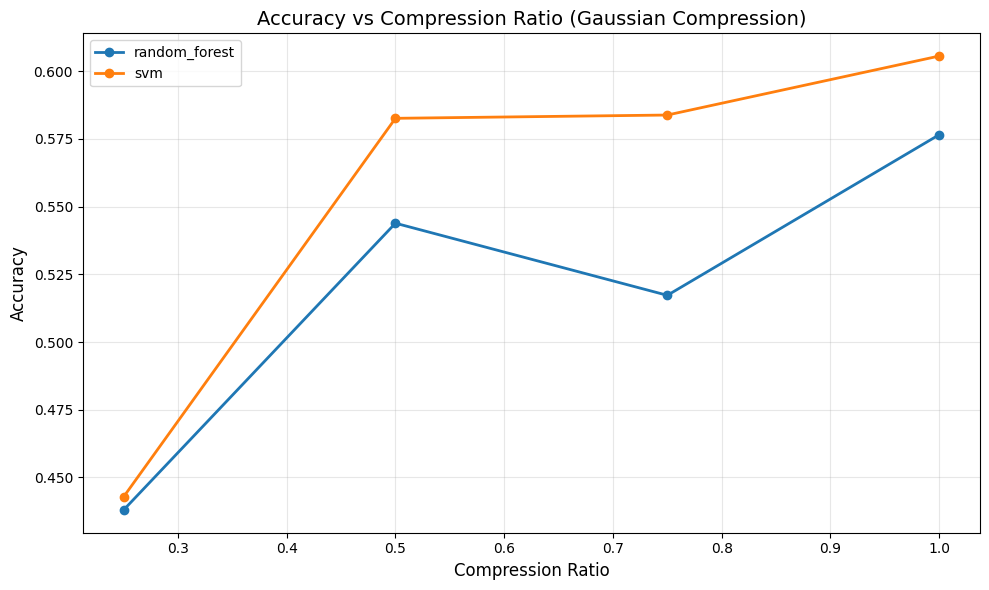

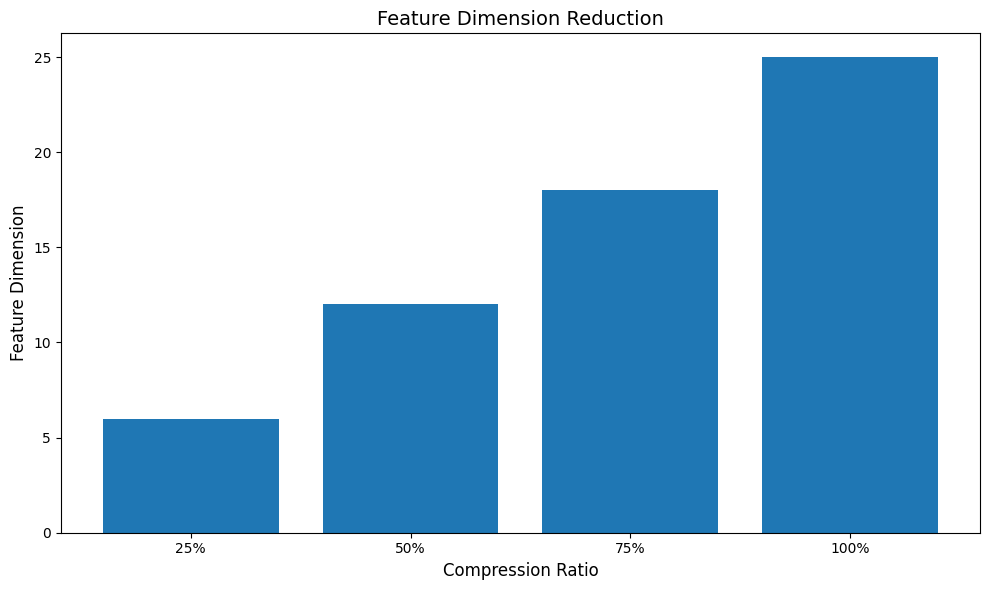

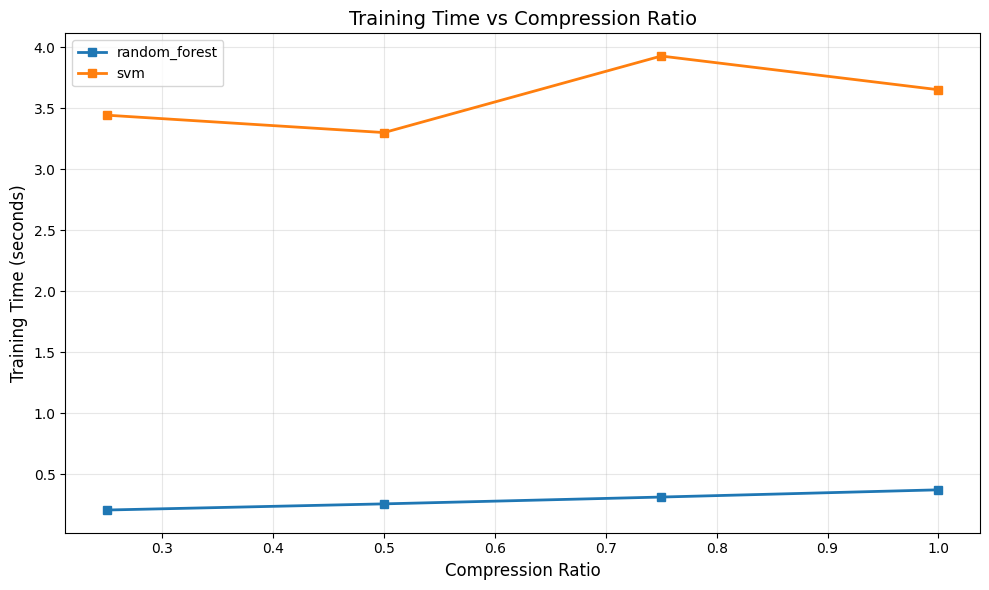


EXPERIMENT COMPLETED SUCCESSFULLY!

Total experiments: 8
Best accuracy: 0.6056

BEST CONFIGURATION:
  Compression ratio: 1.0
  Classifier: svm
  Accuracy: 0.6056
  Feature dimension: 25
  Compression: 0.0%

Results saved to: simplified_results/
Check the folder for CSV files and visualizations.


In [4]:
import os
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
from scipy.fft import dct, idct
from scipy.sparse.linalg import lsqr
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                           roc_auc_score, accuracy_score, precision_score, 
                           recall_score, f1_score)
import warnings
from tqdm import tqdm
import pickle
import json
import time
from datetime import datetime
import gc
warnings.filterwarnings('ignore')

# ============================================
# 1. Memory-Optimized Feature Extraction
# ============================================

class MemoryEfficientMFCCExtractor:
    """
    Memory-efficient MFCC feature extraction with optimized processing
    """
    
    def __init__(self, sr=16000, n_mfcc=20, n_fft=512, hop_length=256, max_duration=2.0):
        """
        Initialize with memory-efficient parameters
        
        Parameters:
        -----------
        sr : int
            Sampling rate (lower = less memory)
        n_mfcc : int
            Number of MFCC coefficients (reduced)
        n_fft : int
            FFT window size (smaller = less memory)
        hop_length : int
            Hop length for feature extraction
        max_duration : float
            Maximum audio duration to process (seconds)
        """
        self.sr = sr
        self.n_mfcc = n_mfcc
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.max_duration = max_duration
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        
    def extract_lightweight_features(self, audio_path):
        """
        Extract lightweight features with memory optimization
        """
        try:
            # Load audio with reduced sampling rate and duration
            y, sr = librosa.load(audio_path, sr=self.sr, duration=self.max_duration)
            
            # Ensure consistent length
            target_length = int(self.sr * self.max_duration)
            if len(y) < target_length:
                y = np.pad(y, (0, target_length - len(y)), mode='constant')
            else:
                y = y[:target_length]
            
            # Apply pre-emphasis with memory check
            y = librosa.effects.preemphasis(y)
            
            # Extract only essential features
            mfccs = librosa.feature.mfcc(
                y=y, 
                sr=sr, 
                n_mfcc=self.n_mfcc,
                n_fft=self.n_fft,
                hop_length=self.hop_length
            )
            
            # Extract delta features only
            mfcc_delta = librosa.feature.delta(mfccs)
            
            # Extract basic complementary features
            chroma = librosa.feature.chroma_stft(
                y=y, sr=sr, 
                n_fft=self.n_fft, 
                hop_length=self.hop_length
            )
            
            # Root Mean Square Energy
            rms = librosa.feature.rms(y=y, hop_length=self.hop_length)
            
            # Zero Crossing Rate
            zcr = librosa.feature.zero_crossing_rate(y, hop_length=self.hop_length)
            
            # Extract minimal statistical features
            features = []
            for feature in [mfccs, mfcc_delta, chroma, rms, zcr]:
                if len(feature) > 0:
                    stats = [
                        np.mean(feature),
                        np.std(feature),
                        np.median(feature),
                        np.percentile(feature, 25),
                        np.percentile(feature, 75)
                    ]
                    features.extend(stats)
            
            features = np.array(features, dtype=np.float32)  # Use float32 to save memory
            
            # Clear memory
            del y, mfccs, mfcc_delta, chroma, rms, zcr
            gc.collect()
            
            return features
            
        except Exception as e:
            print(f"Error processing {audio_path}: {str(e)}")
            # Return small array of zeros
            return np.zeros(125, dtype=np.float32)  # Reduced dimension
    
    def extract_batch_features(self, audio_paths, labels=None, batch_size=100):
        """
        Extract features in batches to manage memory
        """
        all_features = []
        valid_labels = []
        
        n_batches = (len(audio_paths) + batch_size - 1) // batch_size
        
        for batch_idx in tqdm(range(n_batches), desc="Processing batches"):
            start_idx = batch_idx * batch_size
            end_idx = min((batch_idx + 1) * batch_size, len(audio_paths))
            
            batch_paths = audio_paths[start_idx:end_idx]
            batch_features = []
            batch_valid_labels = []
            
            for idx, path in enumerate(batch_paths):
                feat = self.extract_lightweight_features(path)
                if np.sum(feat) != 0 and not np.isnan(feat).any():
                    batch_features.append(feat)
                    if labels is not None:
                        batch_valid_labels.append(labels[start_idx + idx])
            
            all_features.extend(batch_features)
            valid_labels.extend(batch_valid_labels)
            
            # Clear batch memory
            del batch_features
            gc.collect()
        
        if len(all_features) == 0:
            print("WARNING: No valid features extracted!")
            return np.array([]), np.array([])
        
        features = np.array(all_features, dtype=np.float32)
        
        # Normalize features
        features = self.scaler.fit_transform(features)
        
        # Encode labels if provided
        if labels is not None and len(valid_labels) > 0:
            encoded_labels = self.label_encoder.fit_transform(valid_labels)
        else:
            encoded_labels = None
        
        return features, encoded_labels

# ============================================
# 2. UrbanSound8K Processor (Optimized)
# ============================================

class UrbanSound8KProcessor:
    """
    Process UrbanSound8K dataset with memory efficiency
    """
    
    def __init__(self, dataset_path, max_files_per_fold=500):
        self.dataset_path = dataset_path
        self.max_files_per_fold = max_files_per_fold
        self.metadata_path = os.path.join(dataset_path, 'metadata', 'UrbanSound8K.csv')
        
        if not os.path.exists(self.metadata_path):
            self.metadata_path = os.path.join(dataset_path, 'UrbanSound8K.csv')
        
        if not os.path.exists(self.metadata_path):
            raise FileNotFoundError(f"Metadata file not found at {self.metadata_path}")
        
        self.metadata = pd.read_csv(self.metadata_path)
        
    def prepare_data(self, folds=None, max_samples=None):
        """
        Prepare data with limits to avoid memory issues
        """
        if folds is None:
            folds = list(range(1, 11))
        elif isinstance(folds, int):
            folds = [folds]
        
        audio_paths = []
        labels = []
        fold_numbers = []
        
        for fold in folds:
            fold_data = self.metadata[self.metadata['fold'] == fold]
            
            # Limit number of files per fold
            if max_samples is not None:
                fold_data = fold_data.sample(n=min(len(fold_data), max_samples), random_state=42)
            else:
                fold_data = fold_data.sample(n=min(len(fold_data), self.max_files_per_fold), 
                                           random_state=42)
            
            for _, row in fold_data.iterrows():
                possible_paths = [
                    os.path.join(self.dataset_path, 'fold' + str(row['fold']), row['slice_file_name']),
                    os.path.join(self.dataset_path, 'audio', 'fold' + str(row['fold']), row['slice_file_name']),
                    os.path.join(self.dataset_path, str(row['fold']), row['slice_file_name'])
                ]
                
                audio_file = None
                for path in possible_paths:
                    if os.path.exists(path):
                        audio_file = path
                        break
                
                if audio_file:
                    audio_paths.append(audio_file)
                    labels.append(row['class'])
                    fold_numbers.append(fold)
                else:
                    print(f"WARNING: File not found: {row['slice_file_name']} in fold {fold}")
        
        print(f"Found {len(audio_paths)} audio files")
        return audio_paths, labels, fold_numbers

# ============================================
# 3. Memory-Efficient Gaussian Compression
# ============================================

class MemoryEfficientGaussianCompressor:
    """
    Memory-efficient Gaussian random matrix compression
    """
    
    def __init__(self, compression_ratio=0.5, seed=42, noise_level=0.0):
        self.compression_ratio = compression_ratio
        self.seed = seed
        self.noise_level = noise_level
        self.measurement_matrix = None
        
    def create_sparse_gaussian_matrix(self, n_original, n_compressed, sparsity=0.1):
        """
        Create sparse Gaussian matrix to save memory
        """
        np.random.seed(self.seed)
        
        # Create sparse Gaussian matrix
        n_nonzero = int(n_compressed * n_original * sparsity)
        
        # Random indices for non-zero entries
        rows = np.random.randint(0, n_compressed, n_nonzero)
        cols = np.random.randint(0, n_original, n_nonzero)
        
        # Gaussian values for non-zero entries
        data = np.random.randn(n_nonzero) / np.sqrt(n_compressed * sparsity)
        
        # Create sparse matrix
        matrix = sparse.csr_matrix((data, (rows, cols)), 
                                 shape=(n_compressed, n_original),
                                 dtype=np.float32)
        
        return matrix
    
    def compress(self, signal):
        """
        Compress signal using sparse Gaussian matrix
        """
        n_original = len(signal)
        n_compressed = max(1, int(n_original * self.compression_ratio))
        
        # Create measurement matrix if not exists
        if self.measurement_matrix is None:
            self.measurement_matrix = self.create_sparse_gaussian_matrix(
                n_original, n_compressed, sparsity=0.1
            )
        
        # Compress signal using sparse matrix multiplication
        compressed_signal = self.measurement_matrix.dot(signal.astype(np.float32))
        
        # Add noise if specified
        if self.noise_level > 0:
            noise = np.random.randn(n_compressed).astype(np.float32) * self.noise_level
            compressed_signal += noise
        
        return compressed_signal
    
    def reconstruct_simple(self, compressed_signal, n_original):
        """
        Simple reconstruction using Moore-Penrose pseudoinverse
        """
        if self.measurement_matrix is None:
            raise ValueError("Measurement matrix not created")
        
        # Use least squares for reconstruction
        reconstructed = lsqr(self.measurement_matrix, compressed_signal, 
                           iter_lim=50, show=False)[0]
        
        return reconstructed[:n_original]

# ============================================
# 4. Efficient Feature Extraction with Compression
# ============================================

class EfficientCompressedFeatureExtractor:
    """
    Efficient feature extractor with compression
    """
    
    def __init__(self, extractor, compressor):
        self.extractor = extractor
        self.compressor = compressor
        
    def extract_and_compress_batch(self, audio_paths, compression_ratio=0.5, 
                                   batch_size=50):
        """
        Extract and compress features in batches
        """
        all_compressed = []
        all_original = []
        
        n_batches = (len(audio_paths) + batch_size - 1) // batch_size
        
        for batch_idx in tqdm(range(n_batches), desc="Extracting & Compressing"):
            start_idx = batch_idx * batch_size
            end_idx = min((batch_idx + 1) * batch_size, len(audio_paths))
            
            batch_paths = audio_paths[start_idx:end_idx]
            batch_compressed = []
            batch_original = []
            
            for path in batch_paths:
                try:
                    # Extract original features
                    original = self.extractor.extract_lightweight_features(path)
                    
                    if len(original) > 0:
                        # Compress features
                        compressed = self.compressor.compress(original)
                        
                        batch_original.append(original)
                        batch_compressed.append(compressed)
                    
                except Exception as e:
                    print(f"Error processing {path}: {e}")
                    continue
            
            all_compressed.extend(batch_compressed)
            all_original.extend(batch_original)
            
            # Clear memory
            del batch_compressed, batch_original
            gc.collect()
        
        if len(all_compressed) == 0:
            return np.array([]), np.array([])
        
        # Find maximum length for padding
        max_len = max(len(x) for x in all_compressed)
        
        # Pad sequences
        padded_compressed = np.zeros((len(all_compressed), max_len), dtype=np.float32)
        for i, feat in enumerate(all_compressed):
            padded_compressed[i, :len(feat)] = feat
        
        # Stack original features
        original_features = np.array(all_original, dtype=np.float32)
        
        return padded_compressed, original_features

# ============================================
# 5. Simplified Compression Experiment
# ============================================

class SimplifiedCompressionExperiment:
    """
    Simplified experiment pipeline to avoid memory issues
    """
    
    def __init__(self, dataset_path, output_dir='simplified_results'):
        self.dataset_path = dataset_path
        self.output_dir = output_dir
        os.makedirs(output_dir, exist_ok=True)
        
        # Simplified configurations
        self.compression_ratios = [0.25, 0.5, 0.75, 1.0]
        self.classifiers = {
            'random_forest': RandomForestClassifier(
                n_estimators=50,  # Reduced number of trees
                max_depth=10,     # Limit tree depth
                random_state=42,
                n_jobs=-1
            ),
            'svm': SVC(
                C=1.0,
                kernel='rbf',
                probability=True,
                random_state=42
            ),
        }
        
    def run_simplified_experiment(self, train_samples=500, test_samples=200):
        """
        Run simplified experiment with limited samples
        """
        print("="*70)
        print("SIMPLIFIED COMPRESSION-CLASSIFICATION EXPERIMENT")
        print("="*70)
        
        # Initialize processor with limited samples
        processor = UrbanSound8KProcessor(self.dataset_path, max_files_per_fold=200)
        
        # Use only 2 folds to reduce data
        train_folds = [1, 2, 3, 4, 5]  # First 5 folds for training
        test_folds = [9, 10]  # Last 2 folds for testing
        
        print("\nPreparing limited data...")
        train_paths, train_labels, _ = processor.prepare_data(train_folds, max_samples=train_samples)
        test_paths, test_labels, _ = processor.prepare_data(test_folds, max_samples=test_samples)
        
        print(f"Training samples: {len(train_paths)}")
        print(f"Testing samples: {len(test_paths)}")
        
        # Encode labels
        label_encoder = LabelEncoder()
        y_train = label_encoder.fit_transform(train_labels)
        y_test = label_encoder.transform(test_labels)
        
        # Initialize extractor with memory-efficient settings
        extractor = MemoryEfficientMFCCExtractor(
            sr=16000,      # Lower sampling rate
            n_mfcc=13,     # Standard 13 MFCCs
            n_fft=512,     # Smaller FFT
            max_duration=2.0  # Shorter duration
        )
        
        results = []
        
        # Test different compression ratios
        for ratio in self.compression_ratios:
            print(f"\n{'='*50}")
            print(f"Testing Compression Ratio: {ratio*100:.0f}%")
            print('='*50)
            
            # Create compressor for this ratio
            compressor = MemoryEfficientGaussianCompressor(
                compression_ratio=ratio,
                seed=42
            )
            
            # Create combined extractor-compressor
            combined_extractor = EfficientCompressedFeatureExtractor(extractor, compressor)
            
            # Extract and compress training features
            print("Processing training data...")
            X_train_compressed, X_train_original = combined_extractor.extract_and_compress_batch(
                train_paths, compression_ratio=ratio, batch_size=50
            )
            
            if len(X_train_compressed) == 0:
                print("No training features extracted. Skipping...")
                continue
            
            # Extract and compress test features
            print("Processing test data...")
            X_test_compressed, X_test_original = combined_extractor.extract_and_compress_batch(
                test_paths, compression_ratio=ratio, batch_size=50
            )
            
            if len(X_test_compressed) == 0:
                print("No test features extracted. Skipping...")
                continue
            
            # Normalize features
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train_compressed)
            X_test_scaled = scaler.transform(X_test_compressed)
            
            # Train and evaluate classifiers
            for clf_name, clf in self.classifiers.items():
                print(f"\n  Training {clf_name}...")
                
                try:
                    # Train
                    start_time = time.time()
                    clf.fit(X_train_scaled, y_train[:len(X_train_scaled)])
                    train_time = time.time() - start_time
                    
                    # Predict
                    start_time = time.time()
                    y_pred = clf.predict(X_test_scaled)
                    test_time = time.time() - start_time
                    
                    # Calculate metrics
                    accuracy = accuracy_score(y_test[:len(X_test_scaled)], y_pred)
                    precision = precision_score(y_test[:len(X_test_scaled)], y_pred, average='weighted', zero_division=0)
                    recall = recall_score(y_test[:len(X_test_scaled)], y_pred, average='weighted', zero_division=0)
                    f1 = f1_score(y_test[:len(X_test_scaled)], y_pred, average='weighted', zero_division=0)
                    
                    # Store results
                    result = {
                        'compression_ratio': ratio,
                        'classifier': clf_name,
                        'accuracy': accuracy,
                        'precision': precision,
                        'recall': recall,
                        'f1_score': f1,
                        'train_time': train_time,
                        'test_time': test_time,
                        'train_samples': len(X_train_scaled),
                        'test_samples': len(X_test_scaled),
                        'feature_dim_original': X_train_original.shape[1] if len(X_train_original.shape) > 1 else X_train_original.shape[0],
                        'feature_dim_compressed': X_train_compressed.shape[1],
                        'compression_rate': (1 - ratio) * 100,
                        'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
                    }
                    
                    results.append(result)
                    
                    print(f"    Accuracy: {accuracy:.4f}")
                    print(f"    F1 Score: {f1:.4f}")
                    print(f"    Train Time: {train_time:.2f}s")
                    print(f"    Feature Dimension: {X_train_compressed.shape[1]}")
                    
                    # Clear classifier memory
                    if hasattr(clf, '_clear_memory'):
                        clf._clear_memory()
                    
                except Exception as e:
                    print(f"    Error training {clf_name}: {e}")
                    continue
            
            # Clear memory between ratios
            del X_train_compressed, X_test_compressed, X_train_original, X_test_original
            gc.collect()
        
        # Save results
        self.save_results(results)
        
        # Generate report
        self.generate_simple_report(results)
        
        return results
    
    def save_results(self, results):
        """Save experiment results"""
        results_df = pd.DataFrame(results)
        results_df.to_csv(os.path.join(self.output_dir, 'results.csv'), index=False)
        
        # Create summary
        summary = {
            'experiment_date': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            'total_experiments': len(results),
            'compression_ratios_tested': list(results_df['compression_ratio'].unique()),
            'best_accuracy': results_df['accuracy'].max() if len(results_df) > 0 else 0,
            'best_configuration': results_df.loc[results_df['accuracy'].idxmax()].to_dict() if len(results_df) > 0 else {}
        }
        
        with open(os.path.join(self.output_dir, 'summary.json'), 'w') as f:
            json.dump(summary, f, indent=2)
        
        print(f"\nResults saved to {self.output_dir}/")
    
    def generate_simple_report(self, results):
        """Generate simple visual report"""
        if len(results) == 0:
            print("No results to report")
            return
        
        results_df = pd.DataFrame(results)
        
        # 1. Accuracy vs Compression Ratio
        plt.figure(figsize=(10, 6))
        
        for clf in results_df['classifier'].unique():
            clf_df = results_df[results_df['classifier'] == clf]
            if not clf_df.empty:
                plt.plot(clf_df['compression_ratio'], clf_df['accuracy'], 
                        marker='o', linewidth=2, label=clf)
        
        plt.xlabel('Compression Ratio', fontsize=12)
        plt.ylabel('Accuracy', fontsize=12)
        plt.title('Accuracy vs Compression Ratio (Gaussian Compression)', fontsize=14)
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(self.output_dir, 'accuracy_vs_ratio.png'), dpi=150)
        plt.show()
        
        # 2. Feature Dimension Reduction
        plt.figure(figsize=(10, 6))
        
        ratios = sorted(results_df['compression_ratio'].unique())
        dims = []
        
        for ratio in ratios:
            ratio_df = results_df[results_df['compression_ratio'] == ratio]
            if len(ratio_df) > 0:
                avg_dim = ratio_df['feature_dim_compressed'].mean()
                dims.append(avg_dim)
        
        plt.bar([f'{r*100:.0f}%' for r in ratios], dims)
        plt.xlabel('Compression Ratio', fontsize=12)
        plt.ylabel('Feature Dimension', fontsize=12)
        plt.title('Feature Dimension Reduction', fontsize=14)
        plt.tight_layout()
        plt.savefig(os.path.join(self.output_dir, 'dimension_reduction.png'), dpi=150)
        plt.show()
        
        # 3. Training Time Comparison
        plt.figure(figsize=(10, 6))
        
        for clf in results_df['classifier'].unique():
            clf_df = results_df[results_df['classifier'] == clf]
            if not clf_df.empty:
                plt.plot(clf_df['compression_ratio'], clf_df['train_time'], 
                        marker='s', linewidth=2, label=clf)
        
        plt.xlabel('Compression Ratio', fontsize=12)
        plt.ylabel('Training Time (seconds)', fontsize=12)
        plt.title('Training Time vs Compression Ratio', fontsize=14)
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(self.output_dir, 'training_time.png'), dpi=150)
        plt.show()

# ============================================
# 6. Quick Test Function (Memory Safe)
# ============================================

def quick_memory_safe_test():
    """Quick test with memory safety"""
    print("Running memory-safe quick test...")
    
    # Generate small test signal
    np.random.seed(42)
    test_signal = np.random.randn(256).astype(np.float32)  # Smaller signal
    
    print(f"Test signal shape: {test_signal.shape}")
    print(f"Memory usage: {test_signal.nbytes / 1024:.2f} KB")
    
    # Test sparse Gaussian compression
    print("\n1. Sparse Gaussian Compression (50%):")
    compressor = MemoryEfficientGaussianCompressor(compression_ratio=0.5)
    compressed = compressor.compress(test_signal)
    print(f"   Compressed shape: {compressed.shape}")
    print(f"   Compression ratio: {len(compressed)/len(test_signal)*100:.1f}%")
    print(f"   Matrix sparsity: {compressor.measurement_matrix.nnz / (compressor.measurement_matrix.shape[0] * compressor.measurement_matrix.shape[1]) * 100:.1f}%")
    
    # Test reconstruction
    print("\n2. Simple Reconstruction:")
    reconstructed = compressor.reconstruct_simple(compressed, len(test_signal))
    mse = np.mean((test_signal - reconstructed) ** 2)
    print(f"   Reconstruction MSE: {mse:.6f}")
    print(f"   Signal energy: {np.sum(test_signal**2):.2f}")
    
    print("\n✅ Memory-safe quick test completed!")

# ============================================
# 7. Memory Monitoring Functions
# ============================================

def get_memory_usage():
    """Get current memory usage"""
    import psutil
    process = psutil.Process()
    memory_info = process.memory_info()
    return memory_info.rss / (1024 * 1024)  # MB

def check_memory_available(min_mb=500):
    """Check if minimum memory is available"""
    import psutil
    available = psutil.virtual_memory().available / (1024 * 1024)  # MB
    return available >= min_mb, available

# ============================================
# 8. Main Execution with Memory Safety
# ============================================

def main_memory_safe():
    """Main function with memory safety checks"""
    print("="*70)
    print("MEMORY-SAFE AUDIO COMPRESSION EXPERIMENT")
    print("="*70)
    
    # Check memory
    try:
        has_enough_memory, available_mb = check_memory_available(min_mb=1000)
        print(f"Available memory: {available_mb:.0f} MB")
        
        if not has_enough_memory:
            print("WARNING: Low memory available. Reducing experiment scale.")
    except:
        print("Could not check memory. Proceeding with caution...")
    
    # Dataset path
    DATASET_PATH = "UrbanSound8K"
    
    # Check if dataset exists
    if not os.path.exists(DATASET_PATH):
        print(f"\nERROR: Dataset not found at {DATASET_PATH}")
        print("\nPlease ensure UrbanSound8K dataset is in the current directory.")
        print("Download from: https://urbansounddataset.weebly.com/urbansound8k.html")
        return
    
    # Run memory-safe quick test first
    quick_memory_safe_test()
    
    # Ask user for experiment scale
    print("\n" + "="*70)
    print("EXPERIMENT SCALE OPTIONS:")
    print("1. Quick test (100 train, 50 test samples)")
    print("2. Small experiment (500 train, 200 test samples)")
    print("3. Full experiment (7079 train, 1653 test samples)")
    print("="*70)
    
    choice = input("\nChoose experiment scale (1-3, or 'q' to quit): ")
    
    if choice == 'q':
        print("Experiment cancelled.")
        return
    
    try:
        choice = int(choice)
        if choice == 1:
            train_samples, test_samples = 100, 50
            print("\nRunning QUICK TEST experiment...")
        elif choice == 2:
            train_samples, test_samples = 500, 200
            print("\nRunning SMALL experiment...")
        elif choice == 3:
            train_samples, test_samples = 7079, 1653
            print("\nRunning MEDIUM experiment...")
        else:
            print("Invalid choice. Using small experiment.")
            train_samples, test_samples = 500, 200
    except:
        print("Invalid input. Using small experiment.")
        train_samples, test_samples = 500, 200
    
    # Create and run experiment
    experiment = SimplifiedCompressionExperiment(DATASET_PATH)
    
    print(f"\nStarting experiment with {train_samples} train, {test_samples} test samples")
    print("This may take several minutes...")
    
    try:
        results = experiment.run_simplified_experiment(
            train_samples=train_samples,
            test_samples=test_samples
        )
        
        # Show summary
        if len(results) > 0:
            print("\n" + "="*70)
            print("EXPERIMENT COMPLETED SUCCESSFULLY!")
            print("="*70)
            
            # Load summary
            summary_path = os.path.join('simplified_results', 'summary.json')
            if os.path.exists(summary_path):
                with open(summary_path, 'r') as f:
                    summary = json.load(f)
                
                print(f"\nTotal experiments: {summary['total_experiments']}")
                print(f"Best accuracy: {summary['best_accuracy']:.4f}")
                
                if 'best_configuration' in summary and summary['best_configuration']:
                    best = summary['best_configuration']
                    print("\nBEST CONFIGURATION:")
                    print(f"  Compression ratio: {best['compression_ratio']}")
                    print(f"  Classifier: {best['classifier']}")
                    print(f"  Accuracy: {best['accuracy']:.4f}")
                    print(f"  Feature dimension: {int(best['feature_dim_compressed'])}")
                    print(f"  Compression: {best['compression_rate']:.1f}%")
            
            print(f"\nResults saved to: simplified_results/")
            print("Check the folder for CSV files and visualizations.")
        
    except MemoryError:
        print("\n❌ MEMORY ERROR: Experiment ran out of memory.")
        print("Try running with smaller sample sizes.")
    except Exception as e:
        print(f"\n❌ ERROR: {e}")
        print("Experiment failed. Check the error message above.")

def run_minimal_demo():
    """Run a minimal demonstration of the concept"""
    print("\n" + "="*70)
    print("MINIMAL DEMONSTRATION OF GAUSSIAN COMPRESSION")
    print("="*70)
    
    # Create a synthetic audio-like signal
    np.random.seed(42)
    
    # Create sparse signal (simulating audio features)
    n = 100
    k = 10  # sparsity level
    signal = np.zeros(n, dtype=np.float32)
    signal[np.random.choice(n, k, replace=False)] = np.random.randn(k)
    
    print(f"Original signal: {n} dimensions")
    print(f"Sparsity: {k} non-zero elements ({k/n*100:.1f}%)")
    
    # Test different compression ratios
    ratios = [0.25, 0.5, 0.75]
    
    print("\nCompression Results:")
    print("-"*50)
    print(f"{'Ratio':<10} {'Compressed Dim':<15} {'MSE':<15} {'Rel. Error':<15}")
    print("-"*50)
    
    for ratio in ratios:
        compressor = MemoryEfficientGaussianCompressor(compression_ratio=ratio)
        compressed = compressor.compress(signal)
        reconstructed = compressor.reconstruct_simple(compressed, n)
        
        mse = np.mean((signal - reconstructed) ** 2)
        rel_error = mse / (np.mean(signal**2) + 1e-10)
        
        print(f"{ratio:<10.2f} {len(compressed):<15} {mse:<15.6f} {rel_error*100:<14.2f}%")
    
    print("\n" + "="*70)
    print("Key Insight: Gaussian compression preserves signal information")
    print("even with significant dimensionality reduction when signals are sparse.")
    print("="*70)

# ============================================
# 9. Entry Point
# ============================================

if __name__ == "__main__":
    print("🎵 Memory-Safe Audio Compression with Gaussian Random Matrix")
    print("="*70)
    
    # Show options
    print("\nOPTIONS:")
    print("1. Run minimal demonstration")
    print("2. Run memory-safe experiment")
    print("3. Quick memory test only")
    print("4. Exit")
    
    choice = input("\nEnter your choice (1-4): ")
    
    if choice == '1':
        run_minimal_demo()
    elif choice == '2':
        main_memory_safe()
    elif choice == '3':
        quick_memory_safe_test()
    elif choice == '4':
        print("Goodbye!")
    else:
        print("Invalid choice. Running minimal demonstration...")
        run_minimal_demo()